## NLP ON AMAZON REVIEWS TO PREDICT RATING

### PROBLEM STATEMENT

Sometimes we see that hotels keep getting negative reviews and they do not work on that reviews. It may so happen that due to large inflow of both positive and negative reviews, they skip the reviews where they are required to take actions

### GOAL
My goal is to process the text of reviews and vectorize it. Then i would like to predict if the review is positive or negative. However, the efficiency of models based on which I will compare would be on negative reviews. I will give more importance to the Recall & Precision.

## Dataset
It is taken from Kaggle. This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#NLP (text preprocessing)
#import string package to remove punctuation
import string
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
# to work with regular expressions
import re
# natural language toolkit
import nltk
nltk.download()

#ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LogisticRegression

#Neural Network
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder #data transformation
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


C:\Users\karis\Anaconda3\envs\pythondata\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#setting this option to view more number of words in the text column
pd.set_option('display.max_colwidth', 100)
raw_data=pd.read_csv('Reviews.csv')

In [7]:
raw_data.shape

(568454, 10)

In [102]:
# sum_neg=0
# sum_pos=0
# for rating in raw_data['Score']:
#     if rating < 4:
#         sum_neg=sum_neg+1
#     if rating >= 4 :
#         sum_pos=sum_pos+1
# print(sum_pos)
# print(sum_neg)

In [103]:
# raw_data=data_test.drop(data_test.query('Score >= 4').sample(frac=.90).index)
# raw_data.shape

In [104]:
# raw_data=data_test.drop(data_test.query('Score < 4').sample(frac=.50).index)
# raw_data.shape

From the above table, the columns I would take for the analysis is Score and the text. Let us select this new columns into a new dataframe

In [8]:
data=raw_data[["Text","Score"]]

In [9]:
#Let us rename the column score to rating
data.columns=['Text','Rating']

In [10]:
data.head(2)
data.shape

(568454, 2)

Let us do some initial data cleaning

In [11]:
#Check for null values
print("Number of null in text: {}".format(data['Text'].isnull().sum()))
print("Number of null in Score: {}".format(data['Rating'].isnull().sum()))

Number of null in text: 0
Number of null in Score: 0


In [109]:
#Check for datatypes
data.dtypes

Text      object
Rating     int64
dtype: object

In [110]:
data.head()

,Text,Rating
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati...",4
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...,2
4,Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very qu...,5


## NLP on Text column

### Pre-processing text data

I will carry out the following steps to pre process/ clean the text
1. Remove punctuation
2. Tokenization
3. Remove stopwords
4. Lemmatize/Stem


First step is to work with punctuation. For that i will use re.escape & re.sub from re package to work with special characters.

I will get the entire list of meta characters from string package

### Remove Punctuation
To remove punctuation, we have to use the string package. Let us see what is there in string package!

In [12]:
import string
print(dir(string))
string.punctuation

['Formatter', 'Template', '_ChainMap', '_TemplateMetaclass', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_re', '_string', 'ascii_letters', 'ascii_lowercase', 'ascii_uppercase', 'capwords', 'digits', 'hexdigits', 'octdigits', 'printable', 'punctuation', 'whitespace']


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
data.head(2)

,Text,Rating
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1


In [14]:
# def remove_punct(text):
#     text_nopunct = "".join([char for char in text if char not in string.punctuation])
#     return text_nopunct

# data['body_text_clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [15]:
chars = re.escape(string.punctuation)
def replace_punct(text):
    words=re.sub(r'['+chars+']','',text)
    return words
    
data['body_text_clean'] = data['Text'].apply(lambda x: replace_punct(x))
data.head(2)

,Text,Rating,body_text_clean
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5,I have bought several of the Vitality canned dog food products and have found them all to be of ...
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1,Product arrived labeled as Jumbo Salted Peanutsthe peanuts were actually small sized unsalted No...


### Tokenization

Once the punctuation is removed, we need to tokenize the words into string of words which helps to vectorize. We will use split function and regex to extract the non words.

In [16]:
def tokenize(text):
    words=re.split('\W+', text)
    return words

data['tokenized_text']=data['body_text_clean'].apply(lambda x: tokenize(x.lower()))

In [116]:
data.head(2)

,Text,Rating,body_text_clean,tokenized_text
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5,I have bought several of the Vitality canned dog food products and have found them all to be of ...,"[i, have, bought, several, of, the, vitality, canned, dog, food, products, and, have, found, the..."
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1,Product arrived labeled as Jumbo Salted Peanuts the peanuts were actually small sized unsalted...,"[product, arrived, labeled, as, jumbo, salted, peanuts, the, peanuts, were, actually, small, siz..."


### Remove Stop Words

The third step is to remove stop words. These are type of the words which do not contribute much to the statement like a, an the etc. It reduces the dimensionality or the corpus of the words the model is exposed to. We are going to remove the stopwords from the corpus provided by the nltk package. Let us see what are the stop words in the for us

In [17]:
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
def remove_stop(text):
    words=[stop for stop in text if stop not in stopword] 
    return words
data["text_nostop"]=data["tokenized_text"].apply(lambda x: remove_stop(x))

In [119]:
data.head(4)

,Text,Rating,body_text_clean,tokenized_text,text_nostop
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5,I have bought several of the Vitality canned dog food products and have found them all to be of ...,"[i, have, bought, several, of, the, vitality, canned, dog, food, products, and, have, found, the...","[bought, several, vitality, canned, dog, food, products, found, good, quality, product, looks, l..."
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1,Product arrived labeled as Jumbo Salted Peanuts the peanuts were actually small sized unsalted...,"[product, arrived, labeled, as, jumbo, salted, peanuts, the, peanuts, were, actually, small, siz...","[product, arrived, labeled, jumbo, salted, peanuts, peanuts, actually, small, sized, unsalted, s..."
2,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelati...",4,This is a confection that has been around a few centuries It is a light pillowy citrus gelati...,"[this, is, a, confection, that, has, been, around, a, few, centuries, it, is, a, light, pillowy,...","[confection, around, centuries, light, pillowy, citrus, gelatin, nuts, case, filberts, cut, tiny..."
3,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got thi...,2,If you are looking for the secret ingredient in Robitussin I believe I have found it I got thi...,"[if, you, are, looking, for, the, secret, ingredient, in, robitussin, i, believe, i, have, found...","[looking, secret, ingredient, robitussin, believe, found, got, addition, root, beer, extract, or..."


### Lemmatize / Stemming
This is an another step to clean the text and reduce the corpus of the words a model is exposed to. Multiple representation of the words are normalized by stemming or lemmatizing. There are two ways by which it is achieved. 
1. Stemming: Strips the suffices. The word may not be in the dictionary.
2. Lemmatizing: Reduces to the root word

Stemming is faster than Lemmatizing but Lemmatizing is more accurate as it tracks to the root word. Stemming blindly strips the suffices due to which it does not get normalize properly. So I will go with Lemmatizing.

In [19]:
# print(dir(nltk))
wn=nltk.WordNetLemmatizer()

# ps = nltk.PorterStemmer()

In [20]:
def lemmatize(text):
    words=[wn.lemmatize(word)for word in text]
    return words

In [21]:
data['body_text_lemmatized']=data['text_nostop'].apply(lambda x: lemmatize(x))

In [123]:
data.shape

(568454, 6)

Before moving ahead further, let us take the lemmatized column and the rating column only from the dataset. I would also like make one more column which will give the length of the message of the raw text. This will help me to add another feature which might help to predict the rating

In [22]:
data['Text_Length']=data['Text'].apply(lambda x: len(x))

### Vectorization
It is nothing but the process of encoding the text to numerical features to fit it into the model. There are several process by which we can do the vectorization but I will use Term frequency-inverse document frequency (TF-IDF). It assigns a values based on the below image. Example- 'NLP is interesting'

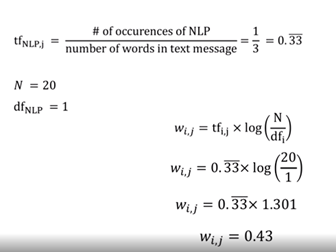

If we look at the formula, high value of first part means the word is frequent in that particular review, and high value of second part means word is rarer across the other reviews. So for that particular review that word is very important. This method helps to pull out important words which is seldom used in other reviews.

In [23]:
tfidf_vect=TfidfVectorizer(analyzer=lemmatize,min_df=0.03, max_df= 0.98)
X_tfidf=tfidf_vect.fit_transform(data['text_nostop'])


TF-IDF tremendously increases the dimensionality of the dataframe. I ran into memory error. So I decided to use min_df and max_df parameters of TfidfVectorizer(). I Ignored the terms that appeared less than 3% and more 98% in the reviews.

In [24]:
df_=pd.DataFrame(X_tfidf.toarray())

In [25]:
print(X_tfidf.shape)
print(tfidf_vect.get_feature_names())

(568454, 220)
['1', '2', '3', '4', '5', 'actually', 'add', 'added', 'almost', 'also', 'always', 'amazon', 'amount', 'another', 'anything', 'around', 'away', 'back', 'bad', 'bag', 'bar', 'best', 'better', 'big', 'bit', 'bottle', 'bought', 'box', 'br', 'brand', 'buy', 'buying', 'calorie', 'came', 'cant', 'case', 'cat', 'chicken', 'chip', 'chocolate', 'coffee', 'come', 'company', 'could', 'cup', 'day', 'definitely', 'delicious', 'didnt', 'diet', 'different', 'doesnt', 'dog', 'dont', 'drink', 'dry', 'easy', 'eat', 'eating', 'enjoy', 'enough', 'even', 'ever', 'every', 'excellent', 'expensive', 'family', 'far', 'favorite', 'feel', 'find', 'first', 'flavor', 'food', 'found', 'free', 'fresh', 'friend', 'full', 'get', 'getting', 'give', 'go', 'going', 'good', 'got', 'great', 'green', 'grocery', 'half', 'happy', 'hard', 'healthy', 'help', 'high', 'highly', 'hot', 'however', 'id', 'ill', 'im', 'ingredient', 'item', 'ive', 'keep', 'kind', 'know', 'last', 'le', 'like', 'little', 'local', 'long', 'l

Concatenated the dataframe created with text length which gives us the independent variable-X_features

In [26]:
X_features = pd.concat([data['Text_Length'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,Text_Length,0,1,2,3,4,5,6,7,8,...,210,211,212,213,214,215,216,217,218,219
0,263,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,190,0.0,0.0,0.0,0.0,0.0,0.481435,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,509,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,219,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,140,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EXPLORATORY DATA ANALYSIS

In [27]:
data_lemmatized=data[['body_text_lemmatized', 'Text_Length','Rating']]

Let us do some exploration with other variables.

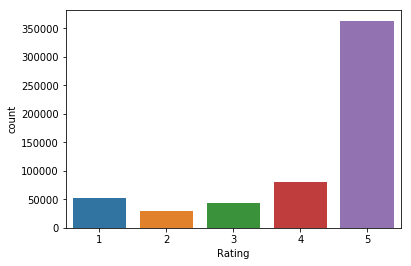

In [79]:
#Count plot of the ratings
sns.countplot(x='Rating', data=data_lemmatized)

We see that there are more reviews on rating 5 comapred to other reviews. The difference in the review count is really huge. I have decided to split the reviews only in two classes.
1. Less than 4 denoted by zero
2. More than 4 denoted by 1

In [28]:
new_score=[]
for score in data['Rating']:
    if score >= 4:
        new_score.append(1)
    if score < 4:
        new_score.append(0)
        


In [29]:
data_lemmatized['Rating']=new_score

In [82]:
data_lemmatized.head(2)

,body_text_lemmatized,Text_Length,Rating
0,"[bought, several, vitality, canned, dog, food, product, found, good, quality, product, look, lik...",263,1
1,"[product, arrived, labeled, jumbo, salted, peanutsthe, peanut, actually, small, sized, unsalted,...",190,0


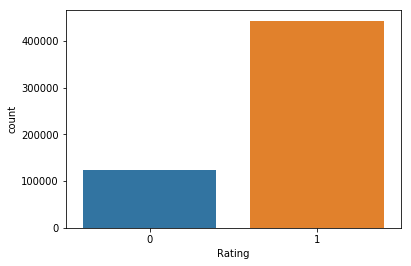

In [83]:
sns.countplot(x='Rating', data=data_lemmatized)

Let us check the distribution of text length with respect to positive and negative reviews

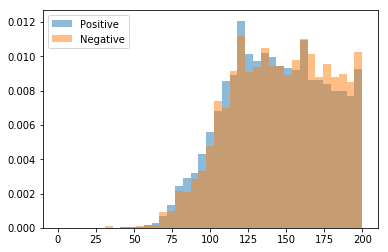

In [84]:
bins = np.linspace(0, 200, 40)

plt.hist(data_lemmatized[data_lemmatized['Rating']==1]['Text_Length'], bins, alpha=0.5, normed=True, label='Positive')
plt.hist(data_lemmatized[data_lemmatized['Rating']==0]['Text_Length'], bins, alpha=0.5, normed=True, label='Negative')

plt.legend(loc='upper left')
plt.show()

We can see the text length do not contribute much to the positive and negative reviews. let us also cross check with the correlation plot.

Text(0.5,1,'Heatmap of Variables')

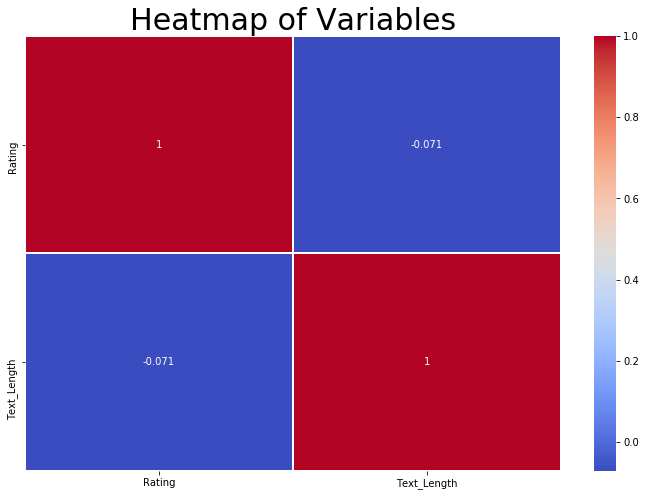

In [85]:
Rev_cor = data_lemmatized[['Rating', 'Text_Length']].corr()

fig = plt.figure(figsize=(12,8))
axes = sns.heatmap(Rev_cor, cmap='coolwarm', linewidth=1, linecolor='white', annot=True)
axes.set_title('Heatmap of Variables', fontsize=30)

Thus, we see that we can remove the Text column if we want it
Now, Let us see the top 30 words in the corpus

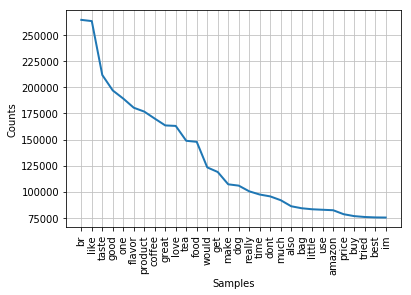

In [86]:
words_split = []
for i in range(0,568453): 
    for word in data['body_text_lemmatized'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

In [87]:
data.head(2)

,Text,Rating,body_text_clean,tokenized_text,text_nostop,body_text_lemmatized,Text_Length
0,I have bought several of the Vitality canned dog food products and have found them all to be of ...,5,I have bought several of the Vitality canned dog food products and have found them all to be of ...,"[i, have, bought, several, of, the, vitality, canned, dog, food, products, and, have, found, the...","[bought, several, vitality, canned, dog, food, products, found, good, quality, product, looks, l...","[bought, several, vitality, canned, dog, food, product, found, good, quality, product, look, lik...",263
1,Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted...,1,Product arrived labeled as Jumbo Salted Peanutsthe peanuts were actually small sized unsalted No...,"[product, arrived, labeled, as, jumbo, salted, peanutsthe, peanuts, were, actually, small, sized...","[product, arrived, labeled, jumbo, salted, peanutsthe, peanuts, actually, small, sized, unsalted...","[product, arrived, labeled, jumbo, salted, peanutsthe, peanut, actually, small, sized, unsalted,...",190


Let us see the high frequency words in both positive and negative reviews

### Positive reviews

In [88]:
data_lemmatized1 = data_lemmatized[data_lemmatized['Rating']==1]
data_lemmatized1.count()

body_text_lemmatized    443777
Text_Length             443777
Rating                  443777
dtype: int64

### High Frequency words in positive reviews

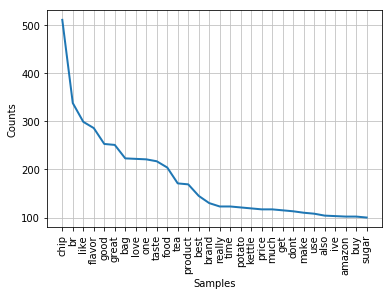

In [89]:
data_lemmatized1 =data_lemmatized1.reset_index(drop=True)
words_split = []
for i in range(0,749): 
    for word in data_lemmatized1['body_text_lemmatized'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

### Wordcloud for positive reviews

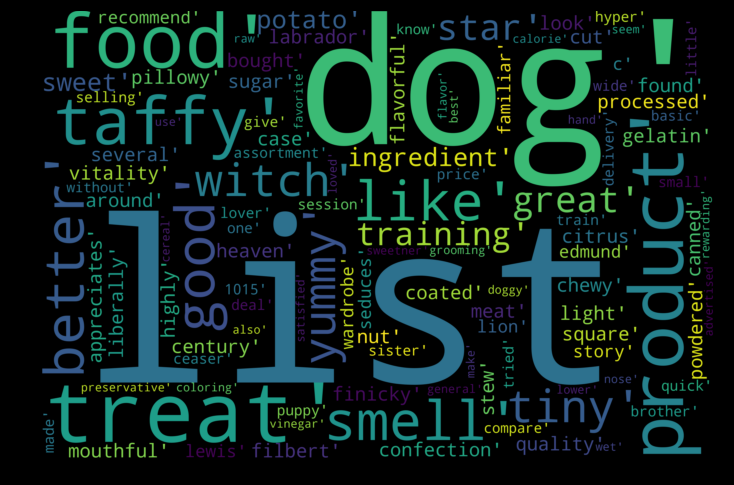

In [90]:
Rating1_text = data_lemmatized1['body_text_lemmatized'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(Rating1_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [91]:
data_lemmatized0 = data_lemmatized[data_lemmatized['Rating']==0]
data_lemmatized0.count()

body_text_lemmatized    124677
Text_Length             124677
Rating                  124677
dtype: int64

### High frequency words for negative reviews

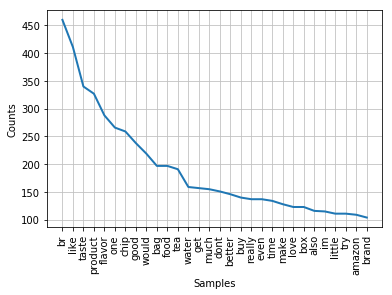

In [92]:
data_lemmatized0 =data_lemmatized0.reset_index(drop=True)
words_split = []
for i in range(0,749): 
    for word in data_lemmatized0['body_text_lemmatized'][i]:
        words_split.append(word)
FreqDist(words_split).plot(30, cumulative=False)

### Word Cloud for negative reviews

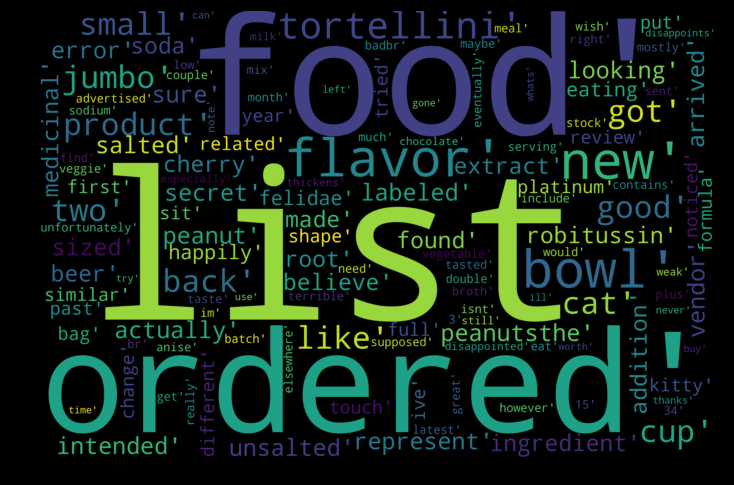

In [93]:
Rating1_text = data_lemmatized0['body_text_lemmatized'].values

wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(Rating1_text))

fig = plt.figure(
    figsize = (10, 7),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

## Build ML Model

### Random Forests Classifier

Just want to have quick look of my accuracy score thorugh K-fold cross validation before moving ahead

In [94]:
rf = RandomForestClassifier(n_jobs=-1)
k_fold = KFold(n_splits=5)
cross_val_score(rf, X_features, data['Rating'], cv=k_fold, scoring='accuracy', n_jobs=-1)

array([0.76634914, 0.7762004 , 0.77598051, 0.79666816, 0.77842378])

### Train Test split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_features, data_lemmatized['Rating'], test_size=0.2)

Since the data was very huge, I skipped grid search and tried to see the effect on scores based on 3 values of n_est and max_depth of the decision trees. Also I chose to calculate the scores based on prediction done on Negative reviews as i feel that Negative reviews should be worked upon rather than positive reviews. 

In [31]:
from sklearn.ensemble import RandomForestClassifier
def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = str(score(y_test, y_pred, pos_label=0, average='binary'))
    print('Est: {} / Depth: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        n_est, depth, round(precision, 3), round(recall, 3),
        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [33]:
for n_est in [10, 50, 100]:
    for depth in [10, 20, 30]:
        train_RF(n_est, depth)

In [36]:
#From above we pick the three values
rf = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.16      0.27     24712
           1       0.81      1.00      0.89     88979

    accuracy                           0.81    113691
   macro avg       0.87      0.58      0.58    113691
weighted avg       0.83      0.81      0.76    113691

[[ 3974 20738]
 [  345 88634]]


### Gradient Boosting

Gradient boosting is another Ensemble ML model which is more effective than Random Forest. Like above, I tried to optimize manually

In [2]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=0, average='binary')
    print('Est: {} / Depth: {} / LR: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
        est, max_depth, lr, round(precision, 3), round(recall, 3), 
        round((y_pred==y_test).sum()/len(y_pred), 3)))

In [34]:
for n_est in [50, 100, 150]:
    for max_depth in [7, 11, 15]:
        for lr in [0.5, 1]:
            train_GB(n_est, max_depth, lr)

In [37]:
#From above we pick the values
gb = GradientBoostingClassifier(n_estimators=100, max_depth=11, learning_rate=1)
gb_model = gb.fit(X_train, y_train)
y_pred = gb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       0.72      0.61      0.66     24712
           1       0.90      0.94      0.92     88979

    accuracy                           0.86    113691
   macro avg       0.81      0.77      0.79    113691
weighted avg       0.86      0.86      0.86    113691

[[15024  9688]
 [ 5757 83222]]


### LOGISTIC REGRESSION
Let us also try with a weak learner

In [38]:
classifier= LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
predictions = classifier.predict(X_test)

In [40]:

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.66      0.42      0.51     24712
           1       0.85      0.94      0.89     88979

    accuracy                           0.83    113691
   macro avg       0.75      0.68      0.70    113691
weighted avg       0.81      0.83      0.81    113691

[[10325 14387]
 [ 5436 83543]]


### DEEP LEARNING
This is the first time I tried to use neural networks. Had to transform the X and y or else the values did not fit into the neural model. I used sequential model and three dense layers with activation relu and softmax. To predict the efficiency, I calculated the accuracy metric

In [41]:
X_scaler = StandardScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [42]:
y_train.shape

(454763,)

In [43]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

# Step 2: Convert encoded labels to one-hot-encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

In [44]:
X_train.shape

(454763, 221)

In [47]:
# Create a Neural Network model here
model = Sequential()
model.add(Dense(units=12, activation='relu', input_dim=221))
model.add(Dense(units=11, activation='relu'))
model.add(Dense(units=2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                2664      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                143       
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 24        
Total params: 2,831
Trainable params: 2,831
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
    X_train_scaled,
    y_train_categorical,
    epochs=60,
    shuffle=True,
    verbose=0
)

In [49]:
model_loss, model_accuracy = model.evaluate(X_test_scaled, y_test_categorical, verbose=2)
print(f"Normal Neural Network - Loss: {model_loss}") 
print(f"Accuracy: {model_accuracy}")

Normal Neural Network - Loss: 0.35679786059345797
Accuracy: 0.839899376386652


## CONCLUSION
1. We see that Gradient Boosting performed best among available models.
2. I also feel that N-grams will give better predictions as for statements like "I like the food" & "I did not like the food", N-grams can perform better.
3. In stop word by nltk package, there are some words like "not" which i believe can strongly impact the positive and negative reviews.